# Fraud Detection
I try to add 2nd order polynomial features for numerical variables, to see whether this'll help the accuracy.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [31]:
data_df = pd.read_pickle('cleaned_features.pkl')
y_label = pd.read_pickle('label.pkl')
feature_columns = data_df.columns

In [3]:
data_df.shape

(2007077, 84)

## Train Logistic Regression with feature scaling

In [4]:
from sklearn.linear_model import LogisticRegression

In [33]:
scaling = preprocessing.StandardScaler()
num_features = ['delay_time','purchase_value','age','device_id_count','ip_address_count']
for col in num_features:
    data_df[col] = scaling.fit_transform(data_df[col].reshape(-1,1))

In [37]:
from sklearn.preprocessing import PolynomialFeatures

In [54]:
# create polynomial features
poly = PolynomialFeatures(degree=2,include_bias=False)
x_poly2 = poly.fit_transform(data_df[num_features])
# get new feature names
new_names = poly.get_feature_names(num_features)
# create a new dataframe
poly_df = pd.DataFrame(x_poly2,columns = new_names)

In [55]:
# add new features to dataframe
data_df = poly_df.join(data_df[data_df.columns[5:]])

In [57]:
# calculate the correlation matrix
df_corr = data_df.corr(method ='spearman')

In [60]:
# create a mask to ignore itself
mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)
df_corr = mask*df_corr

drops = []
for col in df_corr.columns.values:
    if np.in1d([col],drops):
        continue
    corr = df_corr[abs(df_corr[col])>0.98].index
    drops = np.union1d(drops,corr)
print "highly correlated features", drops

highly correlated features ['sex_M']


In [61]:
data_df.drop(drops,axis=1,inplace=True)

In [62]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_df,y_label,test_size=0.33, random_state=42)

In [81]:
LG = LogisticRegression(max_iter = 500,class_weight='balanced',verbose=True)
tuned_parameters = [{'penalty': ['l2'],
                    'C':[10]}]
scores = ['f1']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print 

    LG_clf = GridSearchCV(LG, tuned_parameters, cv=5,
                       scoring = score,verbose=True)
    LG_clf.fit(X_train, y_train)

    print "Best parameters set found on development set:",LG_clf.best_params_
    print
    print "Grid scores on development set:"
    means = LG_clf.cv_results_['mean_test_score']
    stds = LG_clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, LG_clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
    print

    print "Detailed classification report:"
    print 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred,y_prob= y_test, LG_clf.predict(X_test),LG_clf.predict_proba(X_test)
    print classification_report(y_true, y_pred)
    print

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


[LibLinear]Best parameters set found on development set: {'penalty': 'l2', 'C': 10}

Grid scores on development set:
0.619 (+/-0.006) for {'penalty': 'l2', 'C': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96    598528
          1       0.63      0.62      0.62     63808

avg / total       0.93      0.93      0.93    662336




In [70]:
def LG_feature_rank(model,rescale = None, topk=10):

    # get feature names
    feature_names = data_df.columns.tolist()
    
    if rescale:
        # get feature score for normalized data
        norm_feature_score = model.best_estimator_.coef_[0]
        # inverse scaling coefficients
        feature_score = np.true_divide(norm_feature_score,scaling.scale_)
        #absolute score
        abs_score = np.absolute(norm_feature_score)
        feature_df = pd.DataFrame({'feature_names':feature_names,
                               'norm_feature_score':norm_feature_score,
                               'feature_score':feature_score,
                               'abs_score':abs_score
                               })
        # get most siginificant features 
        top_features = feature_df.sort_values('abs_score').iloc[-topk:]
    else:
        # get feature average score
        feature_score = model.best_estimator_.coef_[0]
        abs_score = np.absolute(feature_score)
        feature_df = pd.DataFrame({'feature_names':feature_names,
                                   'feature_score':feature_score,
                                   'abs_score':abs_score
                                 })

    # create a dataframe
    
    # get most siginificant features 
    top_features = feature_df.sort_values('abs_score').iloc[-topk:]
    # generate bar plot
    fig,ax=plt.subplots(figsize=(6,6))
    if rescale:
        ax = top_features['norm_feature_score'].plot.barh(title='feature_importances')
        ax.set_xlabel('normalized_feature score')
    else:
        ax = top_features['feature_score'].plot.barh(title='feature_importances')
        ax.set_xlabel('feature score') 
    ax.set_ylabel('features')
    ax.set_yticklabels(top_features['feature_names'])

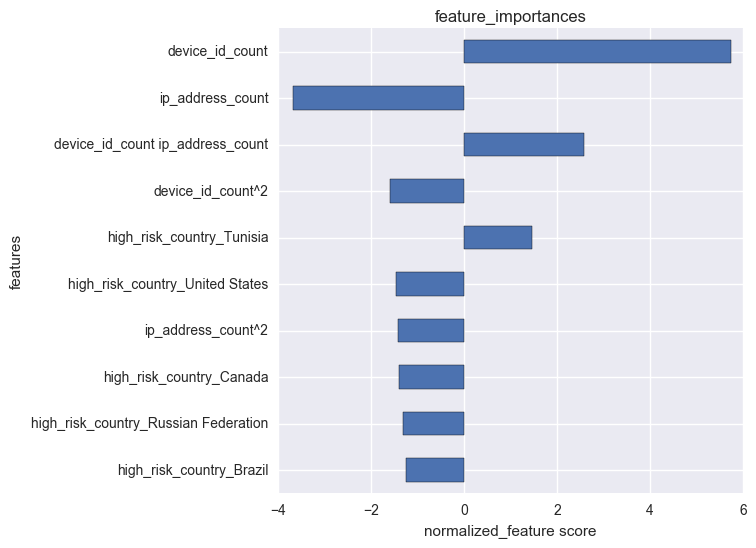

In [82]:
LG_feature_rank(LG_clf,rescale=True)

In [72]:
def plot_confusion_matrix(ytest,ypredict):
    cm =confusion_matrix(ytest, ypredict)
    row_sums = cm.astype('float').sum(axis=1,keepdims=True)
    RF_cm = cm / row_sums
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(RF_cm,annot=True)
    ax.set(xlabel='Predicted Label',ylabel='True Label')

In [75]:
def find_threshold(ytrue,yprob,th =[0.1,0.2,0.3,0.4,0.5]):
    for t in th:
        y_th = (yprob[:,1] > t).astype(int)
        plot_confusion_matrix(ytrue,y_th)

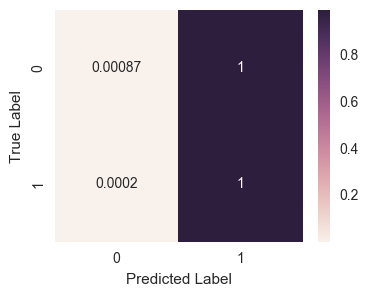

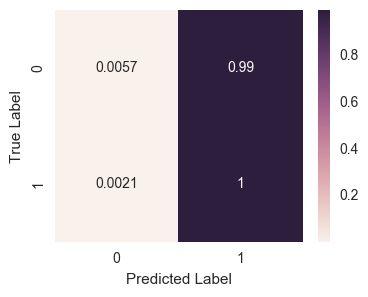

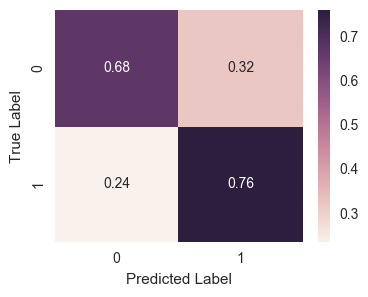

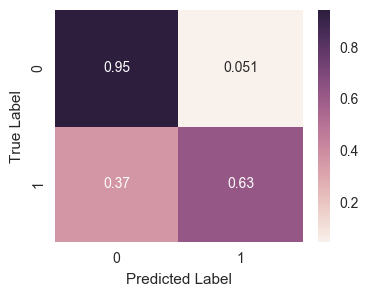

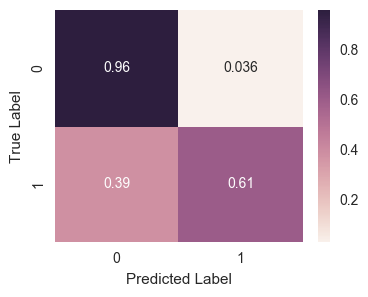

In [76]:
find_threshold(y_true,y_prob)

* Even if I tune the threshold, false negative rate is 38%

In [77]:
def plot_binary_ROC(ytest,ypredict):
    fpr,tpr,_= roc_curve(ytest,ypredict)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve(area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')

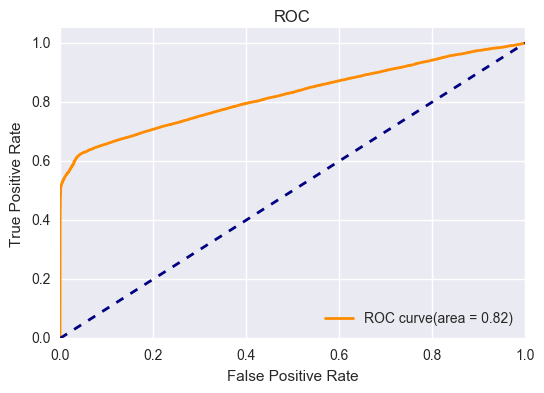

In [78]:
plot_binary_ROC(y_true,y_prob[:,1])